In [104]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

class SinDataset(Dataset):
    def __init__(self, x, included_timesteps, frequency=1):
        """
        Initialize the dataset with the data.

        Args:
            x (list or array-like): Array of numbers representing the input data sequence.
            included_timesteps (int): Number of timesteps to include as input for each sample.
            frequency (float): The frequency for the sine function.
        """
        self.data = x
        self.included_timesteps = included_timesteps
        self.frequency = frequency

    def __len__(self):
        """
        Return the number of samples in the dataset.

        The number of samples is the length of the data minus the number of included timesteps,
        as each sample uses `included_timesteps` data points and predicts the next value.
        """
        return len(self.data) - self.included_timesteps

    def __getitem__(self, idx):
        """
        Fetch the input sequence and its corresponding target at index `idx`.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: 
                x (numpy.ndarray): Array of sine-transformed values for the input sequence of length `included_timesteps`.
                y (float): The sine-transformed value of the next data point (target).
        """
        x = np.sin(self.data[idx:idx + self.included_timesteps] * self.frequency)  # Input sequence
        y = np.sin(self.data[idx + self.included_timesteps] * self.frequency)      # Target value
        return x, y


## Loading data

In [114]:
# Define the number of timesteps to include as input for each sample
included_timesteps = 400

# Create a timeline array with 1000 evenly spaced points between 0 and 120
timeline = np.linspace(0, 120, 2000)

# Create a SinDataset instance `x1` using the timeline, with no shift applied to the sine function
x1 = SinDataset(timeline, included_timesteps)

# Create another SinDataset instance `x2` using the timeline, with a shift of 1 applied to the sine function
x2 = SinDataset(timeline, included_timesteps, frequency=2)

# Initialize a DataLoader for `x1` to iterate through the dataset in batches of size 1
dataloader1 = DataLoader(x1, batch_size=1)

# Initialize a DataLoader for `x2` to iterate through the dataset in batches of size 1
dataloader2 = DataLoader(x2, batch_size=1)


In [107]:
# Loop to remind myself of the dimensions of everything
for (x1, y1), (x2, y2) in zip(dataloader1, dataloader2):
    print(x1.shape, y1.shape, x1.shape, y1.shape)
    x = torch.stack((x1, x2), dim=2).float()
    y = torch.stack((y1, y2), dim=1).float()
    print(x.shape, y.shape)
    break

torch.Size([1, 200]) torch.Size([1]) torch.Size([1, 200]) torch.Size([1])
torch.Size([1, 200, 2]) torch.Size([1, 2])


## Setting up Network

In [108]:
class Net(nn.Module):
    def __init__(self, n_neurons, input_shape):
        super(Net, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=input_shape, hidden_size=n_neurons, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=input_shape, hidden_size=n_neurons, batch_first=True)

        self.fc1 = nn.Linear(n_neurons, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc = nn.Linear(2*n_neurons, 2)
    
    def forward(self, x):
        _, (h_n1, _) = self.lstm1(x[:, :, 0])
        _, (h_n2, _) = self.lstm2(x[:, :, 1])
        out = torch.cat((h_n1, h_n2))
        out = torch.flatten(out)
        out = self.fc(out)
        return out

# Training loop

In [115]:
n_neurons = 12
epochs = 10

model = Net(n_neurons, included_timesteps)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_curve = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

for epoch in range(epochs):
    loss_total = 0
    model.train()

    for (x1, y1), (x2, y2) in zip(dataloader1, dataloader2):
        optimizer.zero_grad()
        x = torch.stack((x1, x2), dim=2).float().to(device)
        y = torch.flatten(torch.stack((y1, y2), dim=1).float()).to(device)

        predictions = model(x)
        loss = loss_function(predictions, y)
        loss_total += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch}: {loss_total=}')


Epoch 0: loss_total=69.68805536086506
Epoch 1: loss_total=15.302648437353696
Epoch 2: loss_total=4.432971114226916
Epoch 3: loss_total=7.550634098634674
Epoch 4: loss_total=6.626704669131641
Epoch 5: loss_total=3.955203622487147
Epoch 6: loss_total=4.724279871485805
Epoch 7: loss_total=4.040857023263015
Epoch 8: loss_total=3.6453343820882083
Epoch 9: loss_total=3.6501088433792575


## Predictions

In [116]:
# Predicting stuff
for (x1, y1), (x2, y2) in zip(dataloader1, dataloader2):
    x = torch.stack((x1, x2), dim=2).float()
    y = torch.flatten(torch.stack((y1, y2), dim=1).float())
    break

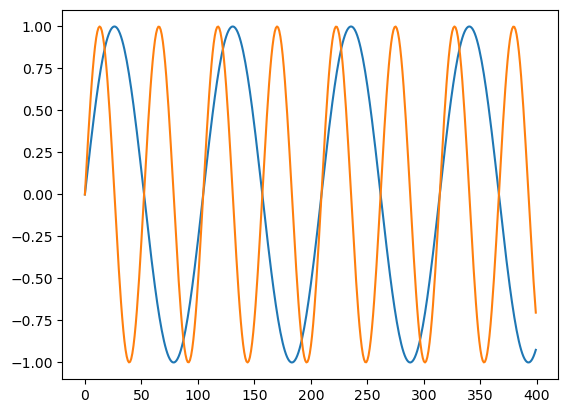

In [117]:
plt.plot(x[0])

In [120]:
prediction = []
for n in range(400):
  pred = model(x)
  y = torch.clone(x[:, 1:, :])
  new_x = pred.reshape((1, 1, 2))
  x = torch.cat((y, new_x), axis=1)
  prediction.append(new_x[0, 0, :].detach().numpy())

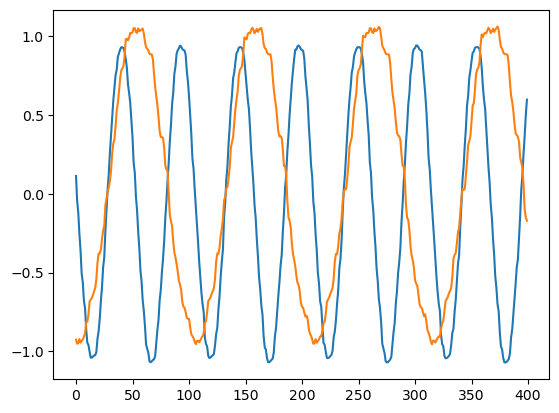

In [121]:
plt.plot(np.array(prediction).T[1])
plt.plot(np.array(prediction).T[0])